# **Dùng thư viện sklearn, chạy lại với các dataset dưới, nhận xét khi thay đổi perplexity**

circles, perplexity=5 in 0.49 sec
circles, perplexity=30 in 0.96 sec
circles, perplexity=50 in 0.73 sec
circles, perplexity=100 in 1.3 sec
S-curve, perplexity=5 in 0.48 sec
S-curve, perplexity=30 in 0.81 sec
S-curve, perplexity=50 in 2.5 sec
S-curve, perplexity=100 in 2.6 sec
uniform grid, perplexity=5 in 1.6 sec
uniform grid, perplexity=30 in 1.4 sec
uniform grid, perplexity=50 in 1.8 sec
uniform grid, perplexity=100 in 2.9 sec


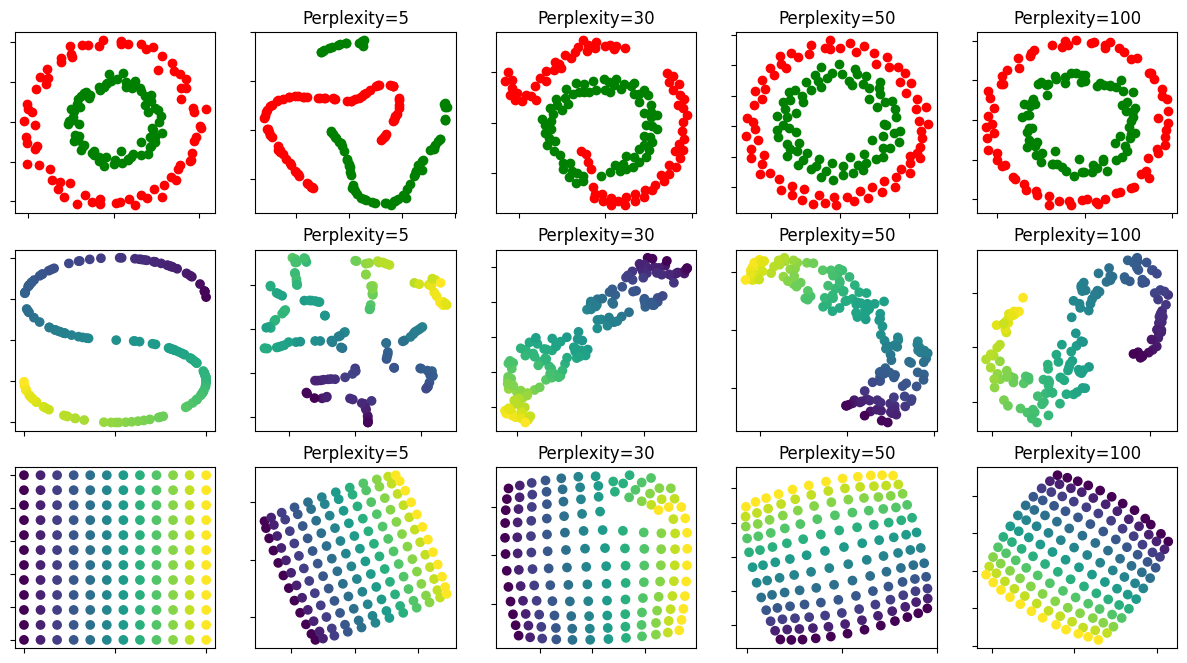

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

n_samples = 150
n_components = 2
(fig, subplots) = plt.subplots(3, 5, figsize=(15, 8))
perplexities = [5, 30, 50, 100]

X, y = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=0
)

red = y == 0
green = y == 1

ax = subplots[0][0]
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i + 1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        n_iter=300,
    )
    Y = tsne.fit_transform(X)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[red, 0], Y[red, 1], c="r")
    ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")

# Another example using s-curve
X, color = datasets.make_s_curve(n_samples, random_state=0)

ax = subplots[1][0]
ax.scatter(X[:, 0], X[:, 2], c=color)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[1][i + 1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        learning_rate="auto",
        n_iter=300,
    )
    Y = tsne.fit_transform(X)
    t1 = time()
    print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")


# Another example using a 2D uniform grid
x = np.linspace(0, 1, int(np.sqrt(n_samples)))
xx, yy = np.meshgrid(x, x)
X = np.hstack(
    [
        xx.ravel().reshape(-1, 1),
        yy.ravel().reshape(-1, 1),
    ]
)
color = xx.ravel()
ax = subplots[2][0]
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[2][i + 1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        n_iter=400,
    )
    Y = tsne.fit_transform(X)
    t1 = time()
    print("uniform grid, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")


plt.show()

# **So sánh PCA và tSNE**

* PCA tries to find a global structure
  * Low dimensional subspace
  * Can lead to local inconsistencies -> Far away point can become nearest neighbors

* t-SNE tries to preserve local structure
  * Low dimensional neu=ighborhood should be the same as original neighborhood




# **Tự implement lại t-SNE, variance có thể fix hoặc từ perplexity tìm ra**

In [2]:

import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold._t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
     

In [4]:
X, y = load_digits(return_X_y=True) 

In [5]:
MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 30

In [6]:
def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    
    # Kullback-Leibler divergence of P and Q
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
    # Gradient: dC/dY
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c
    return kl_divergence, grad

In [7]:
def _gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
        error, grad = obj_func(p, *args)
        grad_norm = linalg.norm(grad)
        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
        print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      % (i + 1, error, grad_norm))
        
        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        
        if grad_norm <= min_grad_norm:
            break
    return p

In [8]:

def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
    params = X_embedded.ravel()
    
    obj_func = _kl_divergence
    
    params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
        
    X_embedded = params.reshape(n_samples, n_components)
    return X_embedded

In [9]:
def fit(X):
    n_samples = X.shape[0]
    
    # Compute euclidean distance
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    # Compute joint probabilities p_ij from distances.
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    
    # The embedding is initialized with iid samples from Gaussians with standard deviation 1e-4.
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    
    # degrees_of_freedom = n_components - 1 comes from
    # "Learning a Parametric Embedding by Preserving Local Structure"
    # Laurens van der Maaten, 2009.
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)

In [10]:
X_embedded = fit(X)

<ipython-input-7-d138dd81716d>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
<ipython-input-7-d138dd81716d>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] Iteration 1: error = 3.9810953, gradient norm = 0.0000046
[t-SNE] Iteration 2: error = 3.9810953, gradient norm = 0.0000048
[t-SNE] Iteration 3: error = 3.9810953, gradient norm = 0.0000058
[t-SNE] Iteration 4: error = 3.9810953, gradient norm = 0.0000087
[t-SNE] Iteration 5: error = 3.9810952, gradient norm = 0.0000149
[t-SNE] Iteration 6: error = 3.9810950, gradient norm = 0.0000272
[t-SNE] Iteration 7: error = 3.9810944, gradient norm = 0.0000527
[t-SNE] Iteration 8: error = 3.9810918, gradient norm = 0.0001082
[t-SNE] Iteration 9: error = 3.9810796, gradient norm = 0.0002342
[t-SNE] Iteration 10: error = 3.9810166, gradient norm = 0.0005328
[t-SNE] Iteration 11: error = 3.9806605, gradient norm = 0.0012673
[t-SNE] Iteration 12: error = 3.9784777, gradient norm = 0.0031211
[t-SNE] Iteration 13: error = 3.9644996, gradient norm = 0.0076109
[t-SNE] Iteration 14: error = 3.8854164, gradient norm = 0.0152470
[t-SNE] Iteration 15: error = 3.6261875, gradient norm = 0.0187792
[t-S